In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_excel(r'/home/sgr/Загрузки/feat_pnt_2018_coh_vhx2.xlsx')
df2=pd.read_csv(r'/home/sgr/Загрузки/feat_pnt_2019_coh_vhx2.csv')
mdf=df.append(df2,ignore_index=True)

In [45]:
del mdf

In [5]:
del df
del df2
mdf['array']=mdf['array'].apply(lambda x:np.array(eval(x)))

In [51]:
mdf.dtypes

system:index     object
array            object
istarget          int64
.geo            float64
dtype: object

In [6]:
X=np.stack(mdf['array'].values)
y=mdf['istarget'].values.astype(int)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Input,Conv1D, Activation, GlobalMaxPooling1D, BatchNormalization, Dense
from tensorflow.keras.models import Model

inp=Input(shape=(16,3))
conv=Conv1D(5, 3, use_bias=False, name='conv1')(inp)
conv=GlobalMaxPooling1D()(conv)
conv = BatchNormalization(momentum=0.8)(conv)

conv=Dense(1,use_bias=True, activation='sigmoid')(conv)
# conv=Dense(1,use_bias=True)(conv)
model=Model(inputs=inp,outputs=conv)

opt=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# filepath=r'/home/sgr/Загрузки/coh_model_simple1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)
# mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=25, verbose=1, min_delta=1e-4, mode='min')

# model.fit(X, y, batch_size=16, epochs=400, verbose=1, callbacks=[earlyStopping, mcp_save,reduce_lr_loss], validation_split=0.2)

model.fit(X, y, batch_size=16, epochs=400, verbose=1, callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.2)
print("train_score", model.evaluate(X, y, batch_size=16, verbose=2))

# model.load_weights(filepath)


# print("train_score", model.evaluate(x_train, y_train, batch_size=16, verbose=2))
# print("valid_score", model.evaluate(x_test, y_test, batch_size=16, verbose=2))

Train on 2570 samples, validate on 643 samples
Epoch 1/400
2570/2570 [==============================] - 1s 294us/sample - loss: 0.9870 - accuracy: 0.3813 - val_loss: 0.9930 - val_accuracy: 0.1742
Epoch 2/400
2570/2570 [==============================] - 0s 119us/sample - loss: 0.7528 - accuracy: 0.4961 - val_loss: 0.7797 - val_accuracy: 0.4168
Epoch 3/400
2570/2570 [==============================] - 0s 132us/sample - loss: 0.6187 - accuracy: 0.6553 - val_loss: 0.7036 - val_accuracy: 0.5490
Epoch 4/400
2570/2570 [==============================] - 0s 120us/sample - loss: 0.5473 - accuracy: 0.7195 - val_loss: 0.3770 - val_accuracy: 0.8896
Epoch 5/400
2570/2570 [==============================] - 0s 129us/sample - loss: 0.5024 - accuracy: 0.7447 - val_loss: 0.6675 - val_accuracy: 0.6532
Epoch 6/400
2570/2570 [==============================] - 0s 119us/sample - loss: 0.4785 - accuracy: 0.7681 - val_loss: 0.8144 - val_accuracy: 0.5054
Epoch 7/400
2570/2570 [==============================] - 0s

In [193]:
df=pd.read_csv(r'/home/sgr/Загрузки/featured_points_coh.csv')

In [18]:
del df

In [5]:
df.columns

Index(['istarget', 's1_2018'], dtype='object')

In [194]:
df['s1_2018']=df['s1_2018'].apply(lambda x:(eval(x)))
# df['s1_2018']=df['s1_2018'].apply(lambda x:np.array(eval(x)))

In [7]:
df.dtypes

istarget     int64
s1_2018     object
dtype: object

In [195]:


arr=df['s1_2018'].values
X=np.array([np.array(i) for i in arr])
X=np.expand_dims(X,axis=-1)

y=df['istarget'].astype(int).values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [12]:
model = tf.keras.models.load_model('my_model.h5')


In [306]:
(0.2*0.2+0.1*0.5+0.8*0.7)*-2+1.6

0.30000000000000027

In [15]:
y_pred=model.predict(X)

In [303]:
model.get_weights()

[array([[[0.193899  ]],
 
        [[0.10519723]],
 
        [[0.8271459 ]]], dtype=float32),
 array([[-1.9613078]], dtype=float32),
 array([1.6342384], dtype=float32)]

In [302]:
model.get_layer(name='conv1').get_weights()

[array([[[0.193899  ]],
 
        [[0.10519723]],
 
        [[0.8271459 ]]], dtype=float32)]

In [313]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Input,Conv1D, Activation, GlobalMaxPooling1D, BatchNormalization, Dense
from tensorflow.keras.models import Model

inp=Input(shape=(16,1))
conv=Conv1D(1, 3, use_bias=False, name='conv1')(inp)
conv=GlobalMaxPooling1D()(conv)
conv = BatchNormalization(momentum=0.8)(conv)
# conv=Activation('sigmoid')(conv)
# conv=Dense(1,use_bias=True, activation='sigmoid')(conv)
conv=Dense(1,use_bias=True)(conv)
model=Model(inputs=inp,outputs=conv)

opt=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

filepath=r'/home/sgr/Загрузки/coh_model_simple1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=25, verbose=1, min_delta=1e-4, mode='min')

model.fit(X, y, batch_size=16, epochs=400, verbose=1, callbacks=[earlyStopping, mcp_save,reduce_lr_loss], validation_split=0.2)

# model.fit(X, y, batch_size=16, epochs=400, verbose=1, callbacks=[mcp_save,reduce_lr_loss], validation_split=0.2)

# model.load_weights(filepath)


print("train_score", model.evaluate(x_train, y_train, batch_size=16, verbose=2))
print("valid_score", model.evaluate(x_test, y_test, batch_size=16, verbose=2))


Train on 2570 samples, validate on 643 samples
Epoch 1/400
2570/2570 [==============================] - 1s 388us/sample - loss: 1.2575 - accuracy: 0.7576 - val_loss: 1.8708 - val_accuracy: 0.6703
Epoch 2/400
2570/2570 [==============================] - 0s 130us/sample - loss: 1.0487 - accuracy: 0.7518 - val_loss: 2.0609 - val_accuracy: 0.5941
Epoch 3/400
2570/2570 [==============================] - 0s 136us/sample - loss: 0.9023 - accuracy: 0.7537 - val_loss: 1.3621 - val_accuracy: 0.6998
Epoch 4/400
2570/2570 [==============================] - 0s 140us/sample - loss: 0.8247 - accuracy: 0.7595 - val_loss: 0.9681 - val_accuracy: 0.7325
Epoch 5/400
2570/2570 [==============================] - 0s 142us/sample - loss: 0.8154 - accuracy: 0.7607 - val_loss: 1.1361 - val_accuracy: 0.7076
Epoch 6/400
2570/2570 [==============================] - 0s 137us/sample - loss: 0.7394 - accuracy: 0.7634 - val_loss: 1.0494 - val_accuracy: 0.7076
Epoch 7/400
2570/2570 [==============================] - 0s

In [314]:
print("train_score", model.evaluate(X, y, batch_size=16, verbose=2))

3213/1 - 1s - loss: 0.3997 - accuracy: 0.7700
train_score [0.514445650319685, 0.7699969]


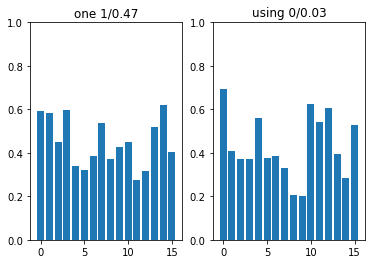

In [98]:
from matplotlib import pyplot as plt

one_ind=np.random.choice(np.where(y==1)[0])
zero_ind=np.random.choice(np.where(y==0)[0])

for num, (line_id, name) in enumerate(zip([one_ind, zero_ind],['one','using'])):
    plt.subplot(1,2,num+1)
    plt.bar(np.arange(16),X[line_id][:,0])
    plt.title(f'{name} {y[line_id]}/{y_pred[line_id][0]:.2f}')
    axes = plt.gca()
    axes.set_ylim([0,1])


In [94]:
test=np.full([16,1], 0.2)
# test[-1]=0.6
test[-1]=0.7
model.predict(test[None,])

array([[0.23055188]], dtype=float32)

In [136]:
import numpy as np

def entropy(bin_arr):
    ln=bin_arr.shape[0]
    ones=np.sum(bin_arr.flatten())
    zeros=ln-ones
    if ones*zeros==0:return 0
    return -ones/ln*np.log2(ones/ln)-zeros/ln*np.log2(zeros/ln)

def conv1d(arr, kernel):    
    arr=arr.flatten()
    kernel=kernel.flatten()
    lenn=kernel.shape[0]    
    arlen=arr.shape[0]
    outt=[]
    for i in range(lenn):
        outt.append(arr[i:arlen-(lenn-i-1)])
    return np.array(outt).T.dot(kernel)
batch_conv1d = np.vectorize(conv1d, signature='(n,m),(k)->(l)')

correlate = np.vectorize(np.correlate, signature='(n),(m)->(k)')



In [179]:
test_X=np.random.rand(20,16,1)
test_y=np.random.randint(0,2,20)

In [198]:
test_X.shape,test_y.shape

((20, 16, 1), (20,))

In [196]:
X.shape, y.shape

((3213, 16, 1), (3213,))

In [197]:
y[0]

0

In [242]:
np.arange(-1,1.1,0.1)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00])

In [255]:
best=0
params={}


X_tr=np.random.rand(3000,16,1)
y_tr=np.random.randint(0,2,3000)

for i in np.arange(-1,1.1,0.1):
    for j in np.arange(-1,1.1,0.1):
#         for ij in np.arange(-1,1.1,0.1):

#         kernel=[-0.4,0.6]
        kernel=[i,j]
        conved=batch_conv1d(X_tr, kernel)
        maxx=conved.max(axis=1)
        maxx[np.argsort(conved)]

        sorted_y=y_tr[np.argsort(maxx)]
        sorted_feat=np.sort(maxx)

        beg_entr=entropy(sorted_y)
        cut_val=0

        cut_ind=0

        arr_len=sorted_y.shape[0]
        for ind in range(1, sorted_y.shape[0]):
            if sorted_y[ind]==sorted_y[ind-1]: continue
            left= sorted_y[:ind]  
            right= sorted_y[ind:]
            l_ent=entropy(left)
            r_ent=entropy(right)    
            cur_entr= (ind-1)/arr_len*l_ent+(arr_len-ind-1)/arr_len*r_ent                

            if cur_entr< beg_entr:
                beg_entr=cur_entr
                cut_val=(sorted_feat[ind-1]+sorted_feat[ind])/2
                cut_ind=ind
        compare_arr=np.zeros(arr_len)
        compare_arr[:cut_ind]=1
        asses=np.sum(compare_arr==sorted_y)/arr_len
        if asses>best:
            best=asses
            params['cut_val']=cut_val
            params['cut_ind']=cut_ind 
            params['beg_entr']=beg_entr
            params['kernel']=kernel

#         np.sum(compare_arr==sorted_y)/arr_len

In [256]:
params, best

({'cut_val': 0.02563241338200064,
  'cut_ind': 1740,
  'beg_entr': 0.995278216939246,
  'kernel': [0.09999999999999964, -0.8]},
 0.5373333333333333)

In [251]:
best

0.7952069716775599

In [252]:
np.sum(sorted_y[:cut_ind])/cut_ind, np.sum(sorted_y[cut_ind:])/(arr_len-cut_ind-1)

(0.7285044293903075, 0.15931941221964424)

In [187]:
sorted_y

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

In [188]:
sorted_feat

array([0.33715315, 0.3726555 , 0.3818512 , 0.41187758, 0.42491575,
       0.43830487, 0.44651313, 0.44728139, 0.4492165 , 0.45072506,
       0.45315965, 0.47120151, 0.48562152, 0.48633297, 0.48824995,
       0.50583116, 0.50998889, 0.54502015, 0.56594494, 0.5768519 ])

In [189]:
(0.50583116+0.50998889)/2

0.5079100249999999

In [148]:
conved.shape

(20, 15)

In [147]:
maxx.shape

(20,)

In [141]:
batch_conv1d(test_X, [0.2,0.5]).shape

(20, 15)

In [142]:
%%timeit
batch_conv1d(test_X, [0.2,0.5])

194 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [139]:
%%timeit
correlate(test_X[:,:,0],[0.2,0.5])

128 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau


model = Sequential()


# inp=Input(input_shape=(16,1))

model.add(Conv1D(40, 2, activation='relu', input_shape=(16,1)))
model.add(Conv1D(40, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(80, 3, activation='relu'))
model.add(Conv1D(160, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


opt=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')



model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

filepath=r'/home/sgr/Загрузки/coh_model1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=15, verbose=1, min_delta=1e-4, mode='min')

model.fit(X, y, batch_size=16, epochs=400, verbose=1, callbacks=[earlyStopping, mcp_save,reduce_lr_loss], validation_split=0.2)


# model.fit(x_train, y_train, batch_size=16, epochs=80)
model.load_weights(filepath)
print("train_score", model.evaluate(x_train, y_train, batch_size=16, verbose=2))
print("valid_score", model.evaluate(x_test, y_test, batch_size=16, verbose=2))

Train on 2570 samples, validate on 643 samples
Epoch 1/400
2570/2570 [==============================] - 1s 338us/sample - loss: 0.6124 - accuracy: 0.6393 - val_loss: 0.6411 - val_accuracy: 0.8087
Epoch 2/400
2570/2570 [==============================] - 0s 156us/sample - loss: 0.4742 - accuracy: 0.7700 - val_loss: 0.7239 - val_accuracy: 0.7030
Epoch 3/400
2570/2570 [==============================] - 0s 179us/sample - loss: 0.4452 - accuracy: 0.7774 - val_loss: 0.7410 - val_accuracy: 0.6703
Epoch 4/400
2570/2570 [==============================] - 1s 195us/sample - loss: 0.4377 - accuracy: 0.7840 - val_loss: 0.6963 - val_accuracy: 0.7061
Epoch 5/400
2570/2570 [==============================] - 1s 208us/sample - loss: 0.4287 - accuracy: 0.7899 - val_loss: 0.6068 - val_accuracy: 0.7714
Epoch 6/400
2570/2570 [==============================] - 1s 241us/sample - loss: 0.4332 - accuracy: 0.7903 - val_loss: 0.5196 - val_accuracy: 0.8149
Epoch 7/400
2570/2570 [==============================] - 0s

In [127]:

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = tf.keras.models.load_model('my_model.h5')

In [30]:
model.input

<tf.Tensor 'conv1d_245_input_1:0' shape=(None, 16, 1) dtype=float32>

In [285]:
from sklearn.model_selection import train_test_split

arr=gg[['vv','vh']].values
ii=np.array([np.array([i[0],i[1]]) for i in arr])
X=np.swapaxes(ii, 1, 2)

#trim 2 first vals for vv, vh
X=X[:,2:,:]


y=gg['cl'].astype(int).values
y=np.reshape(y,(y.size,1))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)




from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(40, 2, activation='relu', input_shape=(15, 2)))
model.add(Conv1D(40, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(80, 3, activation='relu'))
model.add(Conv1D(160, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=16, epochs=40)
score = model.evaluate(x_test, y_test, batch_size=16)
print("train_score", model.evaluate(x_train, y_train, batch_size=16))
print("valid_score", score)

Epoch 1/40
3569/3569 [==============================] - 6s 2ms/step - loss: 0.6176 - acc: 0.6470
Epoch 2/40
3569/3569 [==============================] - 2s 458us/step - loss: 0.4623 - acc: 0.7795
Epoch 3/40
3569/3569 [==============================] - 2s 486us/step - loss: 0.4118 - acc: 0.8100
Epoch 4/40
3569/3569 [==============================] - 3s 830us/step - loss: 0.4009 - acc: 0.8187
Epoch 5/40
3569/3569 [==============================] - 6s 2ms/step - loss: 0.3837 - acc: 0.8299
Epoch 6/40
3569/3569 [==============================] - 5s 2ms/step - loss: 0.3751 - acc: 0.8282
Epoch 7/40
3569/3569 [==============================] - 6s 2ms/step - loss: 0.3532 - acc: 0.8451
Epoch 8/40
3569/3569 [==============================] - 4s 1ms/step - loss: 0.3544 - acc: 0.8434
Epoch 9/40
3569/3569 [==============================] - 8s 2ms/step - loss: 0.3385 - acc: 0.8551
Epoch 10/40
3569/3569 [==============================] - 5s 1ms/step - loss: 0.3305 - acc: 0.8565
Epoch 11/40
3569/3569 [

In [5]:
# serialize model to JSON
model_json = model.to_json()
with open(r"/home/sgr/Загрузки/SXuynia/model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r"/home/sgr/Загрузки/SXuynia/model/model.h5")
print("Saved model to disk")

Saved model to disk


## Make prediction on tf record dataset

In [320]:
import json
# json_file1='data/arrsent1_2018-mixer.json'
OUTPUT_BUCKET='data'
IMAGE_FILE_PREFIX='arrsent1_2019'

# Get a list of all the files in the output bucket.
files_list = !ls {OUTPUT_BUCKET}
# Get only the files generated by the image export.
exported_files_list = [s for s in files_list if IMAGE_FILE_PREFIX in s]

# Get the list of image files and the JSON mixer file.
image_files_list = []
json_file = None
for f in exported_files_list:
    if f.endswith('.tfrecord.gz'):
        image_files_list.append("{0}/{1}".format(OUTPUT_BUCKET,f))
    elif f.endswith('.json'):
        json_file = "{0}/{1}".format(OUTPUT_BUCKET,f)

# Make sure the files are in the right order.
image_files_list.sort()

print(image_files_list)
print(json_file)

# Load the contents of the mixer file to a JSON object.
json_text = !cat {json_file}
# Get a single string w/ newlines from the IPython.utils.text.SList
mixer = json.loads(json_text.nlstr)
print(mixer)
# print(json_text)

['data/arrsent1_2019-00000.tfrecord.gz', 'data/arrsent1_2019-00001.tfrecord.gz', 'data/arrsent1_2019-00002.tfrecord.gz', 'data/arrsent1_2019-00003.tfrecord.gz', 'data/arrsent1_2019-00004.tfrecord.gz', 'data/arrsent1_2019-00005.tfrecord.gz', 'data/arrsent1_2019-00006.tfrecord.gz', 'data/arrsent1_2019-00007.tfrecord.gz', 'data/arrsent1_2019-00008.tfrecord.gz', 'data/arrsent1_2019-00009.tfrecord.gz', 'data/arrsent1_2019-00010.tfrecord.gz', 'data/arrsent1_2019-00011.tfrecord.gz', 'data/arrsent1_2019-00012.tfrecord.gz', 'data/arrsent1_2019-00013.tfrecord.gz', 'data/arrsent1_2019-00014.tfrecord.gz', 'data/arrsent1_2019-00015.tfrecord.gz', 'data/arrsent1_2019-00016.tfrecord.gz', 'data/arrsent1_2019-00017.tfrecord.gz', 'data/arrsent1_2019-00018.tfrecord.gz', 'data/arrsent1_2019-00019.tfrecord.gz', 'data/arrsent1_2019-00020.tfrecord.gz', 'data/arrsent1_2019-00021.tfrecord.gz']
data/arrsent1_2019-mixer.json
{'projection': {'crs': 'EPSG:32635', 'affine': {'doubleMatrix': [20.0, 0.0, 567680.0, 0.0

In [321]:
BANDS=['s1_2019']

patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']

patch_dimensions_flat = [16,patch_width * patch_height]

cols=mixer['patchesPerRow']
rows=int(patches/cols)

image_columns = [tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) ]
image_features_dict = dict(zip(BANDS, image_columns))
# Note that you can make one dataset from many files by specifying a list.
image_dataset = tf.data.TFRecordDataset(image_files_list, compression_type='GZIP')


# Parsing function.
def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, image_features_dict)

# Parse the data into tensors, one long tensor per patch.
image_dataset = image_dataset.map(parse_image, num_parallel_calls=5)


image_dataset = image_dataset.map(lambda features: tf.transpose(list(features.values())), num_parallel_calls=5)


# Break our long tensors into many little ones.
image_dataset = image_dataset.flat_map(
  lambda features: tf.data.Dataset.from_tensor_slices(features)
)

# Turn each patch into a batch.
image_dataset = image_dataset.batch(patch_width * patch_height)

In [322]:
model = tf.keras.models.load_model('my_model.h5')

# Run prediction in batches, with as many steps as there are patches.
predictions = model.predict(image_dataset, steps=patches, verbose=1)

# Note that the predictions come as a numpy array.  Check the first one.
print(predictions[0])
print(predictions.shape)

513/513 [==============================] - 40s 77ms/step
[0.92006546]
(33619968, 1)


In [323]:
# Save predictions in TIFF tiles 1 tile per batch
def save_as_tiff(predictions, mixer, out_dir):
    from osgeo import gdal, osr
    base_trans=mixer['projection']['affine']['doubleMatrix']
    epsg=int(mixer['projection']['crs'].split(':')[1])
    spref=osr.SpatialReference()
    spref.ImportFromEPSG(epsg)
    proj=tt.ExportToWkt()  
    
    patch_width = mixer['patchDimensions'][0]
    patch_height = mixer['patchDimensions'][1]
    patch_lens=patch_width*patch_height
    patches = mixer['totalPatches'] 
    cols=mixer['patchesPerRow']
    rows=int(patches/cols)

    for i in range(patches):
        row=i//cols
        col=i%cols
        dx=patch_width*col
        dy=patch_width*row
        trans=base_trans.copy()
        trans[0]=base_trans[2]+base_trans[0]*dx
        trans[1]=base_trans[0]
        trans[2]=0
        trans[3]=base_trans[-1]+base_trans[-2]*dy
        trans[4]=0
        trans[5]=base_trans[-2]
        curar=predictions[i*patch_lens:(i+1)*patch_lens].reshape(mixer['patchDimensions'])
        trans=tuple(trans)        
        
        to_path='%s/im_%04d.tif' % (out_dir,i)               
        
        driver = gdal.GetDriverByName('GTiff')
        dataset = driver.Create(to_path, patch_width,
                patch_height,
                1,
                gdal.GDT_Float32)
#                                 , options=['COMPRESS=LZW'])
        dataset.SetProjection(proj)
        dataset.SetGeoTransform(trans)
        
        outband = dataset.GetRasterBand(1)
        outband.WriteArray(curar)
        dataset.FlushCache()
        del dataset
        del outband
        del curar
        

In [324]:
out_dir='data/out'
save_as_tiff(predictions, mixer, out_dir)

In [150]:
# NOT NESSESARY Write to tfrecord

OUTPUT_IMAGE_FILE='data/outt.TFRecord'
writer = tf.io.TFRecordWriter(OUTPUT_IMAGE_FILE)

# Every patch-worth of predictions we'll dump an example into the output
# file with a single feature that holds our predictions. Since our predictions
# are already in the order of the exported data, the patches we create here
# will also be in the right order.
patch = []
cur_patch = 1
for prediction in predictions:
    patch.append(prediction)
  
  # Once we've seen a patches-worth of class_ids...
    if (len(patch) == patch_width * patch_height):
        print('Done with patch ' + str(cur_patch) + ' of ' + str(patches) + '...')
        # Create an example
        example = tf.train.Example(
          features=tf.train.Features(
            feature={
              'prediction': tf.train.Feature(
                  float_list=tf.train.FloatList(
                      value=patch))
            }
          )
        )
        # Write the example to the file and clear our patch array so it's ready for
        # another batch of class ids
        writer.write(example.SerializeToString())
        patch = []
        cur_patch += 1

writer.close()

Done with patch 1 of 12...
Done with patch 2 of 12...
Done with patch 3 of 12...
Done with patch 4 of 12...
